In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.special import factorial as ss
from pylab import rcParams
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from numpy import log
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA


In [3]:
dataset = pd.read_csv("AMZN.csv", header=0 )
df = dataset
df = df.drop(["Open", "High","Low","Adj Close","Volume"], axis=1)
df = df.sort_values(by="Date")
print(df.dtypes)
df['Date'] =pd.to_datetime(df['Date'])
print(df.dtypes)

Date      object
Close    float64
dtype: object
Date     datetime64[ns]
Close           float64
dtype: object


In [7]:
df.resample('W', on='Date').sum()

,Close
Date,
2016-05-01,659.590027
2016-05-08,3359.110046
2016-05-15,3523.899963
2016-05-22,3504.700013
2016-05-29,3536.449951
...,...
2021-04-04,12386.100097
2021-04-11,16401.439941
2021-04-18,16890.919922


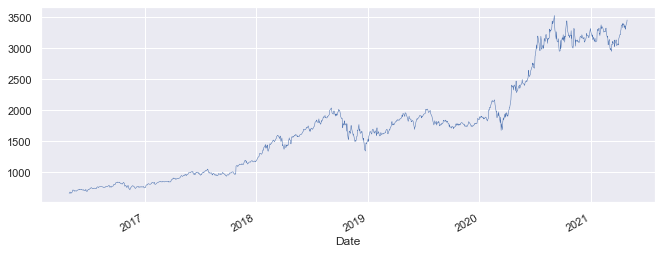

In [43]:
df = df.set_index('Date')
sns.set(rc={'figure.figsize':(11, 4)})
df['Close'].plot(linewidth=0.5);
plt.show()

Benzile Boillinger sunt folosite pentru a definii un posibil high sau low in preturile de pe piata bursiera. Acestea sunt un indicator de volatilitate Benzile sunt, de fapt, linii MA - inferioare si superioare = se adauga sau se scade deviatia standard. 

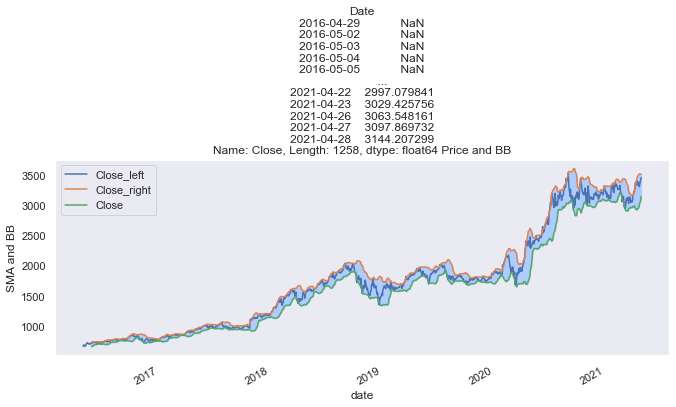

In [44]:
# calculam media mobila pentru 20 de zile
sma = df["Close"].rolling(window=20).mean()
# calculam standard deviation
rstd = df["Close"].rolling(window=20).std()
upper_band = sma + 2 * rstd
lower_band = sma - 2 * rstd
df = df.join(upper_band, on = 'Date',how='left', lsuffix='_left', rsuffix='_right').join(lower_band, on = 'Date',how='left', lsuffix='_left', rsuffix='_right')
ax = df.plot(title='{} Price and BB'.format(df['Close']))
ax.fill_between(df.index, lower_band, upper_band, color='#ADCCFF')
ax.set_xlabel('date')
ax.set_ylabel('SMA and BB')
ax.grid()
plt.show()

Interpretare:
Aproximativ 90% dintre preturile Amazon sunt cuprinse de aceste benzi. Putem folosi aceasta metoda pentru a identifica daca o actiune este sub-apreciata sau supra-apreciata. Daca se afla peste limita superioara -> este supra-apreciata avem un short pe piata. Daca se afla sub linia inferioara -> este sub apreciata avem un long.

AUTOCORELATIA SI CORELATIA PARTIALA

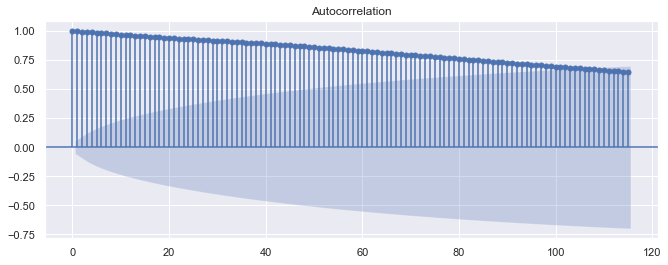

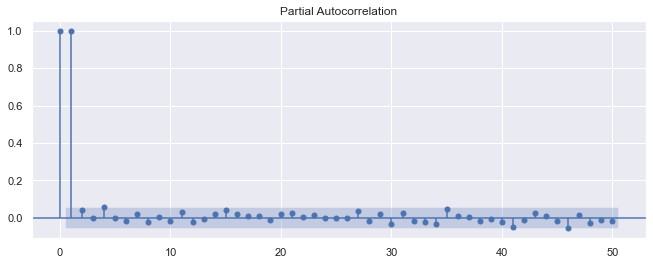

In [45]:
df2 = df.drop(['Close_right', 'Close'], axis=1)
plot_acf(df2["Close_left"],lags=115)
pyplot.show()
plot_pacf(df2, lags=50)
pyplot.show()

<ipython-input-66-bdc83195bbdb>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(x=df2['Close_left'],  freq = 52 , model = 'additive')


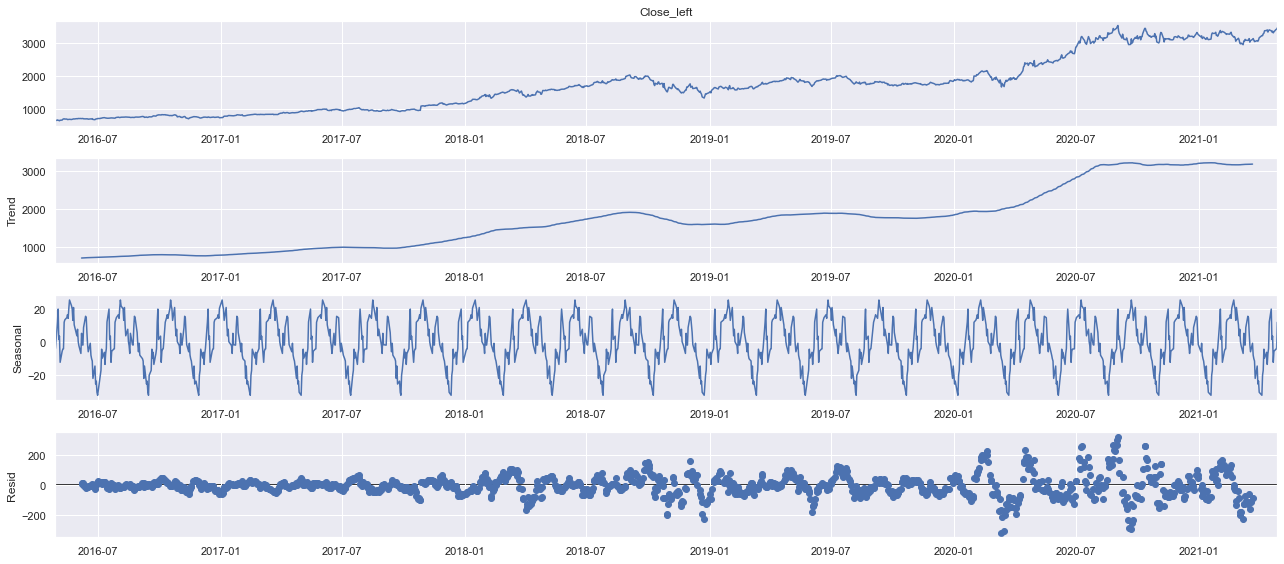

In [66]:
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(x=df2['Close_left'],  freq = 52 , model = 'additive')
fig = decomposition.plot()
plt.show()

In [ ]:
monthly_mean =df2['Close_left'].resample('M').mean()
monthly_mean.plot(figsize=(15, 6))
plt.show()

Logaritmare

In [50]:
import math
X = df2['Close_left']
X = log(X)
X.dropna()
# X.to_csv('log.csv')

Date
2016-04-29    6.491618
2016-05-02    6.527739
2016-05-03    6.509246
2016-05-04    6.508620
2016-05-05    6.490860
                ...   
2021-04-22    8.104413
2021-04-23    8.113989
2021-04-26    8.134174
2021-04-27    8.136644
2021-04-28    8.148590
Name: Close_left, Length: 1258, dtype: float64

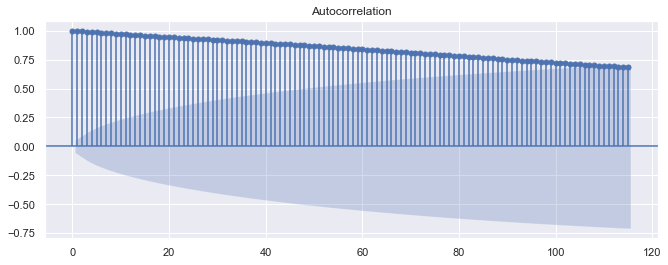

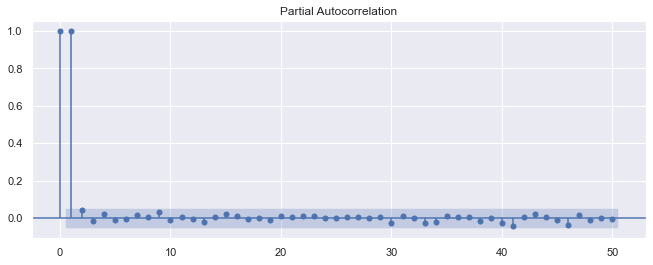

In [51]:
plot_acf(X,lags=115)
pyplot.show()
plot_pacf(X, lags=50)
pyplot.show()

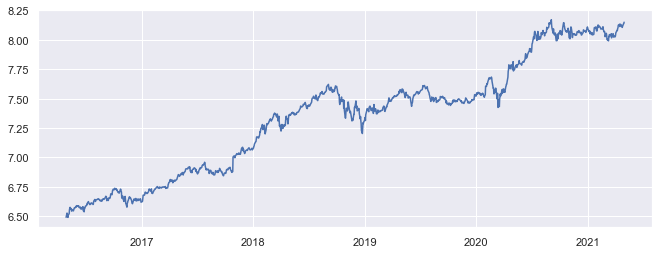

In [52]:
pyplot.plot(X)
pyplot.show()

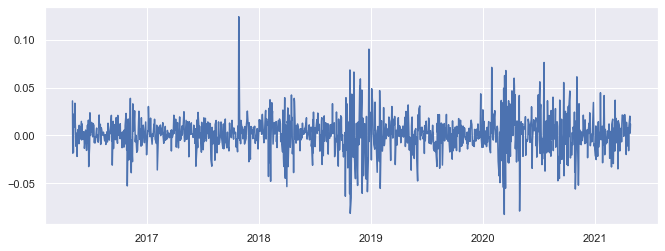

In [53]:
X = X.diff()
X.dropna()
pyplot.plot(X)
pyplot.show()

In [60]:
X = X.iloc[1:]

Date
2016-05-02    True
2016-05-03    True
2016-05-04    True
2016-05-05    True
2016-05-06    True
              ... 
2021-04-22    True
2021-04-23    True
2021-04-26    True
2021-04-27    True
2021-04-28    True
Name: Close_left, Length: 1257, dtype: bool
Date
2016-05-02    0.036120
2016-05-03   -0.018493
2016-05-04   -0.000626
2016-05-05   -0.017760
2016-05-06    0.022296
                ...   
2021-04-22   -0.015884
2021-04-23    0.009576
2021-04-26    0.020185
2021-04-27    0.002470
2021-04-28    0.011946
Name: Close_left, Length: 1257, dtype: float64


In [61]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))   

ADF Statistic: -12.461284
p-value: 0.000000
	1%: -3.436
	5%: -2.864
	10%: -2.568


Autocorelatia si autocorelatia partiala

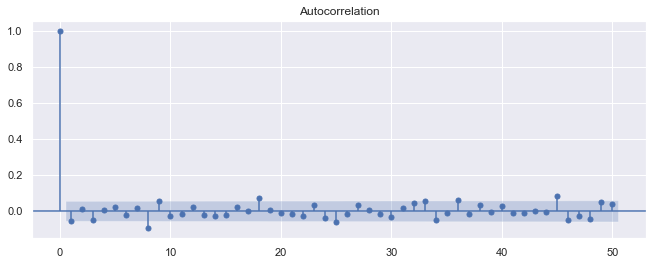

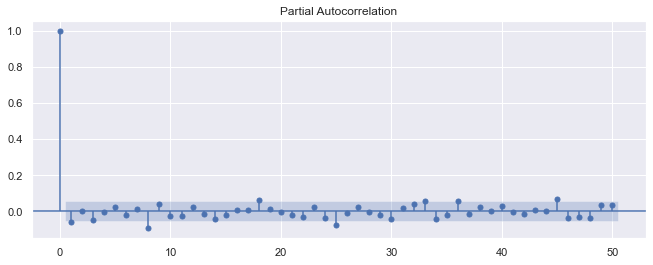

In [63]:
plot_acf(X,lags=50)
pyplot.show()
plot_pacf(X, lags=50)
pyplot.show()

Numar de observatii: 1257
Numar de observatii training: 797
Numar de observatii training testing: 461


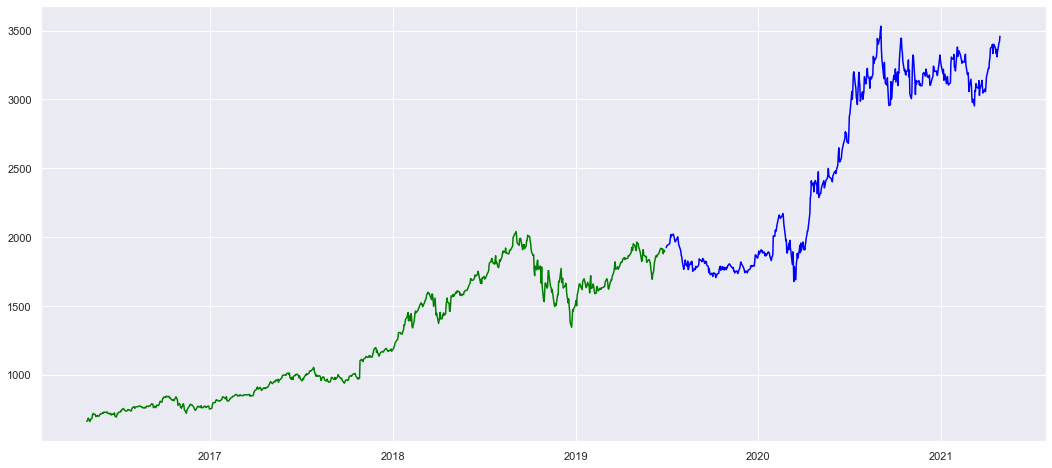

In [142]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df2['Close_left'], train_size=0.634,shuffle=False)
print('Numar de observatii: %d' % (len(X)))
print('Numar de observatii training: %d' % (len(train)))
print('Numar de observatii training testing: %d' % (len(test)))
plt.plot(train, 'green')
plt.plot(test, 'blue')
pyplot.show()

In [163]:
from statsmodels.tsa.arima_model import ARMA
from pandas import DataFrame
from pylab import rcParams, sqrt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# evaluate an ARMA model for a given order (p,q)
def evaluate_arma_model(X, arma_order):
    train, test= train_test_split(df2['Close_left'], train_size=0.634,shuffle=False)
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARMA(history, order=arma_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for q in q_values:
            order = (p, q)
            try:
                rmse = evaluate_arma_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARMA%s RMSE=%.3f' % (order, rmse))
            except:
                continue
    print('Best ARMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
import warnings
warnings.filterwarnings("ignore")
p = q = range(2) 
evaluate_models(X, p, q)

ARMA(0, 0) RMSE=1196.021
ARMA(0, 1) RMSE=618.204
ARMA(1, 0) RMSE=52.764


In [173]:
model00 = ARMA(X, order=(0,0))
model_fit00 = model00.fit(disp=0)
print(model_fit00.summary())

model10 = ARMA(X, order=(1,0))
model_fit10 = model10.fit(disp=0)
print(model_fit10.summary())


                              ARMA Model Results                              
Dep. Variable:             Close_left   No. Observations:                 1257
Model:                     ARMA(0, 0)   Log Likelihood                3245.791
Method:                           css   S.D. of innovations              0.018
Date:                Wed, 05 May 2021   AIC                          -6487.583
Time:                        22:35:55   BIC                          -6477.310
Sample:                             0   HQIC                         -6483.722
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.555      0.011       0.000       0.002
                              ARMA Model Results                              
Dep. Variable:             Close_left   No. Observat

In [98]:
print(train)
print(test)

Date
2016-04-29     659.590027
2016-05-02     683.849976
2016-05-03     671.320007
2016-05-04     670.900024
2016-05-05     659.090027
                 ...     
2019-06-24    1913.900024
2019-06-25    1878.270020
2019-06-26    1897.829956
2019-06-27    1904.280029
2019-06-28    1893.630005
Name: Close_left, Length: 797, dtype: float64
Date
2019-07-01    1922.189941
2019-07-02    1934.310059
2019-07-03    1939.000000
2019-07-05    1942.910034
2019-07-08    1952.319946
                 ...     
2021-04-22    3309.040039
2021-04-23    3340.879883
2021-04-26    3409.000000
2021-04-27    3417.429932
2021-04-28    3458.500000
Name: Close_left, Length: 461, dtype: float64


                               SARIMAX Results                                
Dep. Variable:             Close_left   No. Observations:                  797
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3700.854
Date:                Wed, 05 May 2021   AIC                           7407.707
Time:                        21:00:14   BIC                           7421.750
Sample:                             0   HQIC                          7413.102
                                - 797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3813      2.750      0.502      0.615      -4.008       6.770
ar.L1          0.9989      0.002    476.343      0.000       0.995       1.003
sigma2       627.2639     15.756     39.811      0.0

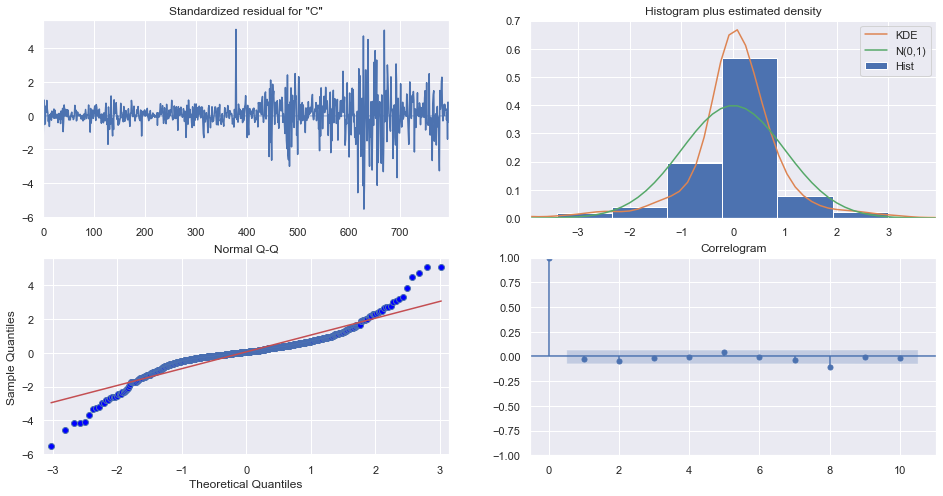

In [113]:
mod = sm.tsa.statespace.SARIMAX(train, trend='c', order=(1,0,0))
res = mod.fit(disp=0)
print(res.summary())
res.plot_diagnostics(figsize=(16, 8))
plt.show()


In [85]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARMA(history, order=(1,0))
    model_fit = model.fit(disp= -1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

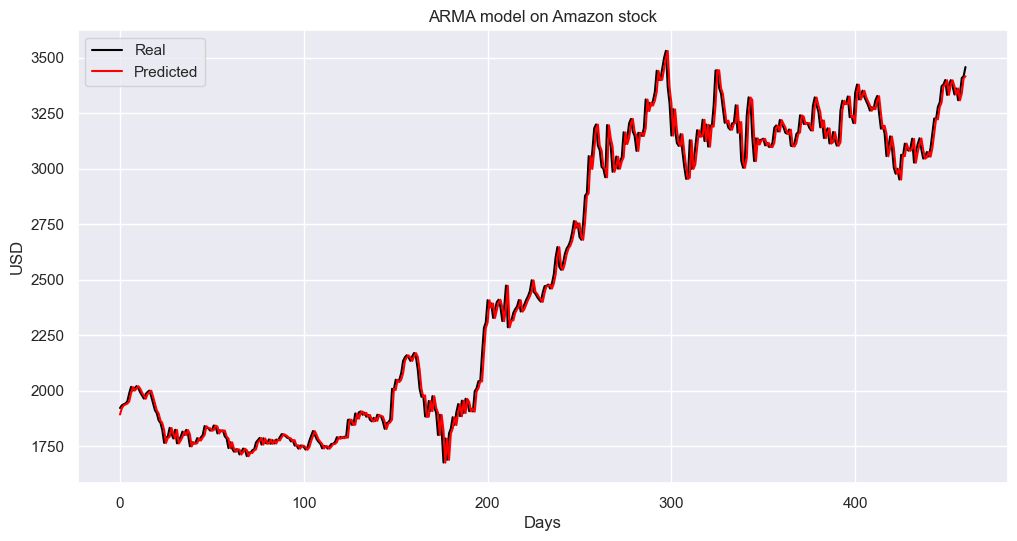

In [78]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test.values, color='black', label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARMA model on Amazon stock')
plt.legend()
plt.show()

In [169]:
print(test)

Date
2019-07-01    1922.189941
2019-07-02    1934.310059
2019-07-03    1939.000000
2019-07-05    1942.910034
2019-07-08    1952.319946
                 ...     
2021-04-22    3309.040039
2021-04-23    3340.879883
2021-04-26    3409.000000
2021-04-27    3417.429932
2021-04-28    3458.500000
Name: Close_left, Length: 461, dtype: float64


KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

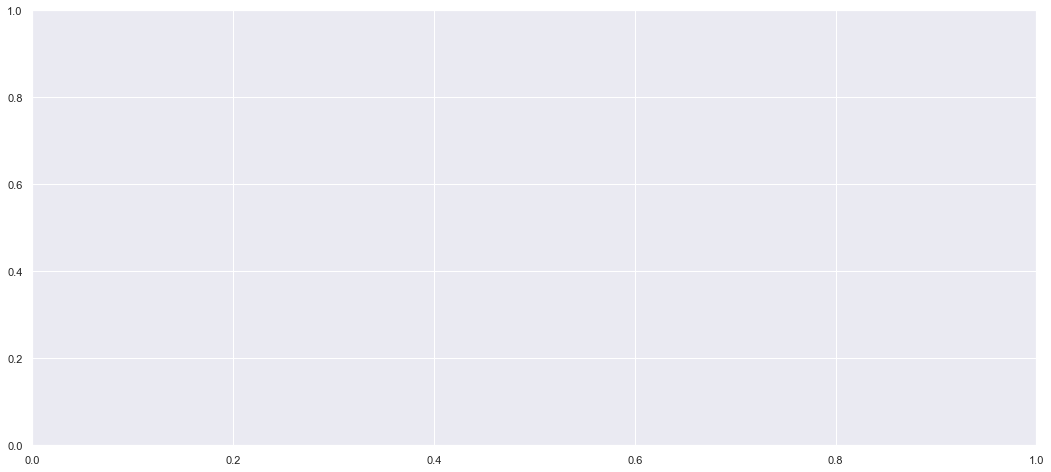

In [172]:
model_fit10.plot_predict(start= pd.to_datetime('2016-04-29'))

# Plot the data
valid = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train)
plt.plot(valid)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

print(res.forecast())
fcast_res1 = res.get_forecast()
print(fcast_res1.summary_frame(alpha=0.05))
fcast_res2 = res.get_forecast(steps=2)
print(fcast_res2.summary_frame())

fig, ax = plt.subplots(figsize=(15, 5))


# Construct the forecasts
fcast = res.get_forecast('2016-04-29').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [93]:
def evaluate_arima_model(X, arima_order):
    train, test= train_test_split(df2['Close_left'], train_size=0.634,shuffle=False)
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_arima(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue 
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [94]:
import warnings
warnings.filterwarnings("ignore")
p = q = d = range(2) 
evaluate_models_arima(train, p, d, q)

ARIMA(0, 0, 0) RMSE=1196.021
ARIMA(0, 0, 1) RMSE=618.204
ARIMA(0, 1, 0) RMSE=52.643
ARIMA(0, 1, 1) RMSE=52.612
ARIMA(1, 0, 0) RMSE=52.753
ARIMA(1, 1, 0) RMSE=52.615
ARIMA(1, 1, 1) RMSE=52.639
Best ARIMA(0, 1, 1) RMSE=52.612


                               SARIMAX Results                                
Dep. Variable:             Close_left   No. Observations:                  797
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3691.535
Date:                Wed, 05 May 2021   AIC                           7389.070
Time:                        21:55:19   BIC                           7403.109
Sample:                             0   HQIC                          7394.464
                                - 797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5625      0.873      1.789      0.074      -0.149       3.274
ma.L1         -0.0248      0.019     -1.287      0.198      -0.063       0.013
sigma2       624.5975     15.707     39.766      0.0

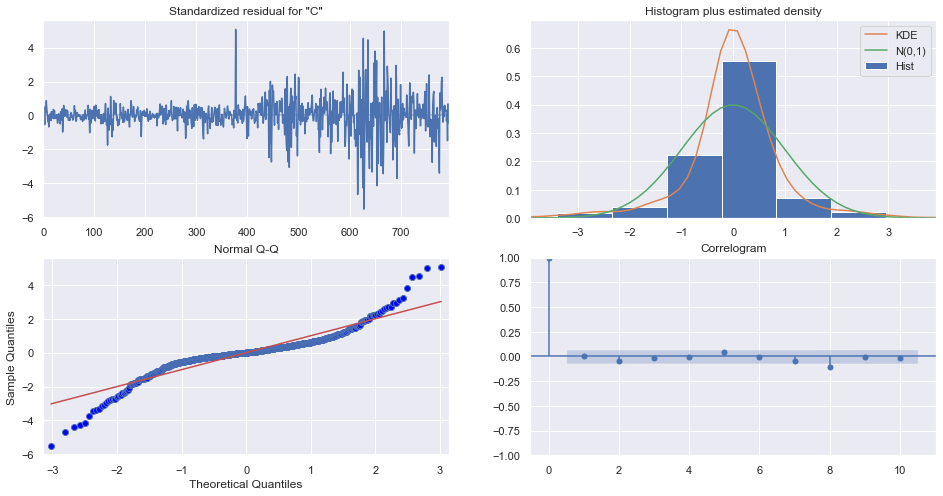

                               SARIMAX Results                                
Dep. Variable:             Close_left   No. Observations:                  797
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3691.558
Date:                Wed, 05 May 2021   AIC                           7389.116
Time:                        21:55:20   BIC                           7403.155
Sample:                             0   HQIC                          7394.510
                                - 797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5567      0.892      1.745      0.081      -0.192       3.305
ar.L1         -0.0222      0.019     -1.169      0.242      -0.059       0.015
sigma2       624.9111     15.698     39.807      0.0

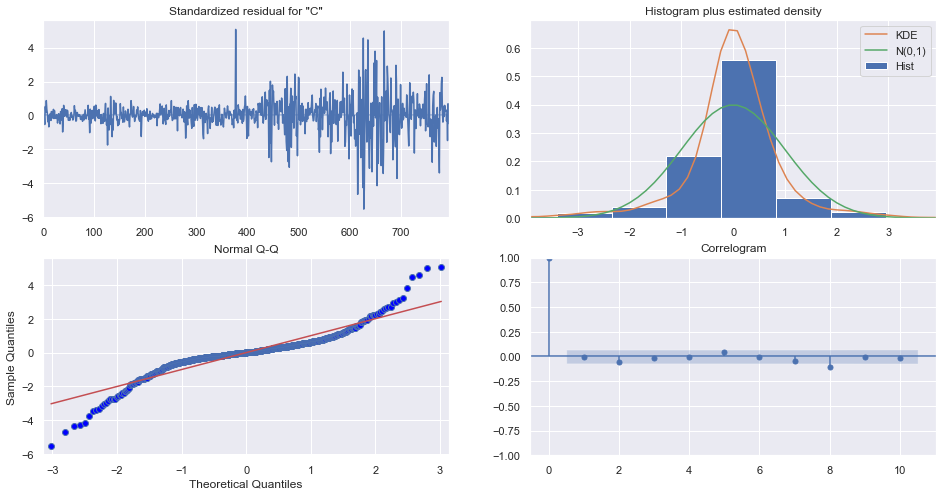

                               SARIMAX Results                                
Dep. Variable:             Close_left   No. Observations:                  797
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3691.755
Date:                Wed, 05 May 2021   AIC                           7387.511
Time:                        21:55:21   BIC                           7396.870
Sample:                             0   HQIC                          7391.107
                                - 797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5503      0.890      1.743      0.081      -0.193       3.294
sigma2       625.0867     15.274     40.926      0.000     595.151     655.022
Ljung-Box (L1) (Q):                   0.40   Jarque-

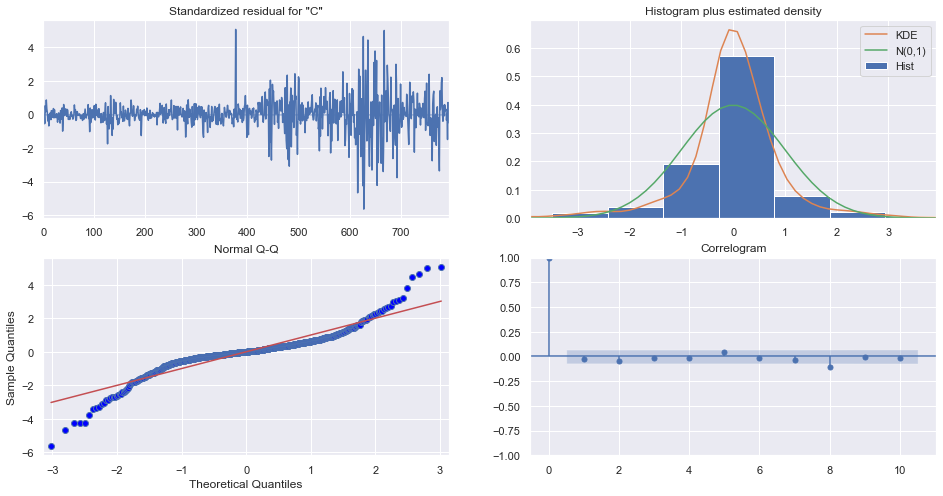

In [162]:
mod = sm.tsa.statespace.SARIMAX(train, trend='c', order=(0,1,1))
res = mod.fit(disp=0)
print(res.summary())
res.plot_diagnostics(figsize=(16, 8))
plt.show()

mod2 = sm.tsa.statespace.SARIMAX(train, trend='c', order=(1,1,0))
res2 = mod2.fit(disp=0)
print(res2.summary())
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

mod3 = sm.tsa.statespace.SARIMAX(train, trend='c', order=(0,1,0))
res3 = mod3.fit(disp=0)
print(res3.summary())
res3.plot_diagnostics(figsize=(16, 8))
plt.show()

In [158]:
res2.forecast(1)

797    1895.42334
dtype: float64

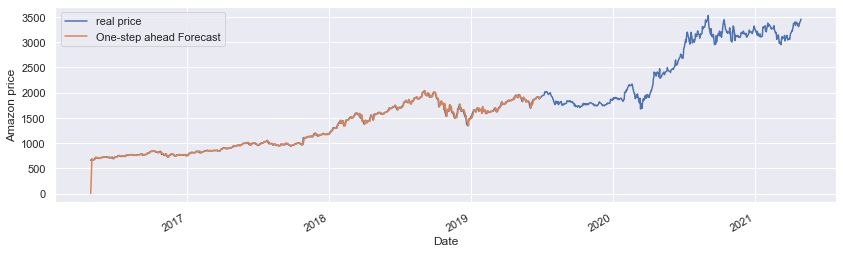

In [159]:
pred = res2.get_prediction(start=pd.to_datetime('2016-04-29'), dynamic=False)
pred_ci = pred.conf_int()
ax = df2['Close_left'].plot(label='real price')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=1, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Amazon price')
plt.legend()
plt.show()

In [160]:
history_arima = [x for x in train]
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history, order=(1, 1, 0))
    model_fit_arima = model_arima.fit(disp= -1)
    output = model_fit_arima.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = test[t]
    history_arima.append(obs)

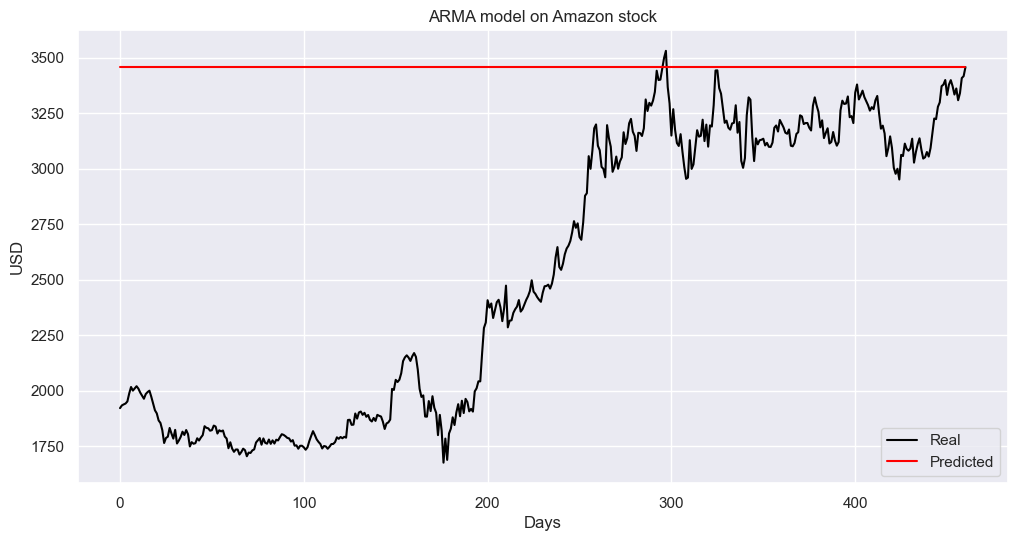

In [161]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test.values, color='black', label='Real')
plt.plot(predictions_arima, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARMA model on Amazon stock')
plt.legend()
plt.show()